In [ ]:
!gdown 1M3Jf3QoxTVy8lDZ4Xb3d9gABu7xPew5A
!unzip chest_xray.zip

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
base_dir = '/content/chest_xray'
batch_size = 32
image_size = 224
learning_rate = 5e-4
epochs = 15
class_labels = ['NORMAL', 'PNEUMONIA']

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   fill_mode = 'nearest',
                                   validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='training'
)

validation_generator = validation_datagen.flow_from_directory(
    os.path.join(base_dir,'train'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary',
    subset='validation'
)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir,'test'),
    target_size=(image_size,image_size),
    batch_size = batch_size,
    class_mode = 'binary'
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


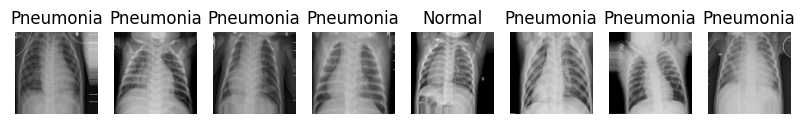

In [5]:
def show_images(generator, num_images = 5):
    images, labels = next(generator)
    plt.figure(figsize=(10,10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i])
        plt.title('Normal' if labels[i] == 0 else 'Pneumonia')
        plt.axis('off')
    plt.show()
show_images(train_generator, num_images=8)

In [ ]:
# model
base_model = tf.keras.applications.ResNet50V2(input_shape=(image_size, image_size, 3),
                                              include_top=False,
                                              weights='imagenet',
                                              pooling='avg')
inputs = base_model.input
x = tf.keras.layers.Dense(128, activation='relu')(base_model.output)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs,outputs)
model.summary()

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

LRS = ReduceLROnPlateau(monitor='val_loss', mode ='min',
                        factor=0.1, patience=3, min_lr=1e-7)
# min_lr LR 감소 한계치
# mode Monitor 가 낮아지는걸 기준으로 ? 아니면 높아지는걸 기준으로 patience?
# factor 몇퍼센트 비율로 LR 감소 시킬지

MC = ModelCheckpoint('checkpoint.tf', monitor='val_loss',
                     mode='min', save_best_only=True)
ES = EarlyStopping(monitor='val_loss', patience=5)


In [8]:
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data= validation_generator,
                    callbacks=[LRS,MC,ES])

Epoch 1/15
131/131 [==============================] - 178s 1s/step - loss: 0.1603 - accuracy: 0.9399 - val_loss: 0.3724 - val_accuracy: 0.9386 - lr: 5.0000e-04
Epoch 2/15
131/131 [==============================] - 135s 1s/step - loss: 0.1028 - accuracy: 0.9631 - val_loss: 0.1007 - val_accuracy: 0.9655 - lr: 5.0000e-04
Epoch 3/15
131/131 [==============================] - 108s 827ms/step - loss: 0.0956 - accuracy: 0.9684 - val_loss: 1.0595 - val_accuracy: 0.7277 - lr: 5.0000e-04
Epoch 4/15
131/131 [==============================] - 108s 824ms/step - loss: 0.0748 - accuracy: 0.9744 - val_loss: 1.0217 - val_accuracy: 0.7267 - lr: 5.0000e-04
Epoch 5/15
131/131 [==============================] - 109s 830ms/step - loss: 0.0737 - accuracy: 0.9760 - val_loss: 1.0275 - val_accuracy: 0.6663 - lr: 5.0000e-04
Epoch 6/15
131/131 [==============================] - 130s 994ms/step - loss: 0.0721 - accuracy: 0.9736 - val_loss: 0.0634 - val_accuracy: 0.9799 - lr: 5.0000e-05
Epoch 7/15
131/131 [========

In [10]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='confusionmatrix'):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i,j],
             horizontalalignment='center',
             color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('GT')
    plt.xlabel('prediction')

In [15]:
!mv /content/checkpoint.tf /content/drive/MyDrive/checkpoint.tf

mv: cannot move '/content/checkpoint.tf' to '/content/drive/MyDrive/checkpoint.tf': No such file or directory


In [14]:
model.load_weights('/content/checkpoint.tf')
prediction = model.predict(test_generator)
predicted_classes = (prediction > 0.5).astype('int').reshape(-1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)

20/20 [==============================] - 7s 369ms/step


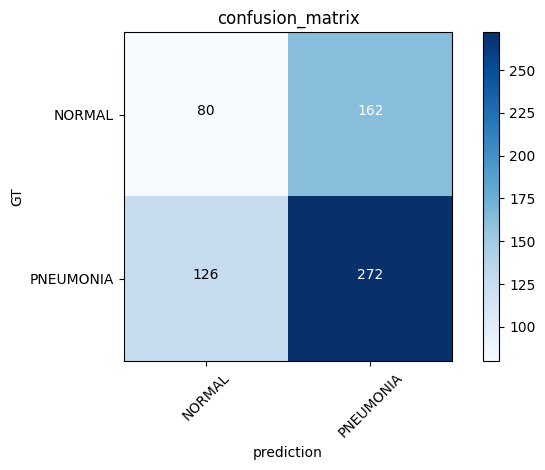

In [12]:
plot_confusion_matrix(conf_matrix,classes=class_labels, title='confusion_matrix')

In [13]:
from sklearn.metrics import classification_report

report = classification_report(true_classes, predicted_classes,
                               target_names = class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.39      0.33      0.36       242
   PNEUMONIA       0.63      0.68      0.65       398

    accuracy                           0.55       640
   macro avg       0.51      0.51      0.51       640
weighted avg       0.54      0.55      0.54       640

